# Plot OSU - CPU data - the ExaBench setup

- `osu_bw`
- `osu_bibw`
- `osu_latency`
- result summary: NONONO
    - #no significant difference between JWB and JRDC results
    - #best combination: OMPI; GPU 0 - 2; for all benchmarks
    - #OMP much better than PSMPI for small msg sizes
    - #GPU combination 0-2 in general better than 0-1 and 0-3

In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

date = '23nov2022'

fname = ['/p/project/jscbenchmark/breuer1/osu-micro-benchmarks/benchmark/data/osu-6_2/cpu/osu_jwb_cpu_psmpi_s23.csv',
         '/p/project/jscbenchmark/breuer1/osu-micro-benchmarks/benchmark/data/osu-6_2/cpu/osu_jwb_cpu_ompi_s23.csv',
         '/p/project/jscbenchmark/breuer1/osu-micro-benchmarks/benchmark/data/osu-6_2/cpu/osu_jrdc_cpu_psmpi_s23.csv',
         '/p/project/jscbenchmark/breuer1/osu-micro-benchmarks/benchmark/data/osu-6_2/cpu/osu_jrdc_cpu_ompi_s23.csv']

#if system == 'jw':
#    ib_tech = 'EDR'
#    ib_max = (100/8)*(64/66)*1000
#elif system == 'JRDC':
#    ib_tech = 'HDR100'
#    ib_max = (100/8)*(64/66)*1000
#elif system == 'jwb':
#    ib_tech = 'HDR200'
#    ib_max = (100/8)*(64/66)*1000
#else:
#    print('no IB value available!!')

In [2]:
bench_data = pd.DataFrame()
for i, filename in enumerate(fname):
    print(i, filename)
    bench_data = bench_data.append(pd.read_csv(filename))
bench_data.rename(columns={'execute_mode': 'mpi'}, inplace=True)
bench_data['mpi_dev'] = bench_data.system + '_' + bench_data.mpi
bench_data = bench_data.reset_index(drop=True)

0 /p/project/jscbenchmark/breuer1/osu-micro-benchmarks/benchmark/data/osu-6_2/cpu/osu_jwb_cpu_psmpi_s23.csv
1 /p/project/jscbenchmark/breuer1/osu-micro-benchmarks/benchmark/data/osu-6_2/cpu/osu_jwb_cpu_ompi_s23.csv
2 /p/project/jscbenchmark/breuer1/osu-micro-benchmarks/benchmark/data/osu-6_2/cpu/osu_jrdc_cpu_psmpi_s23.csv
3 /p/project/jscbenchmark/breuer1/osu-micro-benchmarks/benchmark/data/osu-6_2/cpu/osu_jrdc_cpu_ompi_s23.csv


In [3]:
bench_data

,system,mpi,nodes,taskspernode,osu_exe,msg_size,runtime[sec],size,result,job_id,status,exit_code,mpi_dev
0,JWB,psmpi,1,2,osu_bibw,1,1.80,1,2.08,6360421,COMPLETED,0:0,JWB_psmpi
1,JWB,psmpi,1,2,osu_bibw,16,1.75,16,33.30,6360422,COMPLETED,0:0,JWB_psmpi
2,JWB,psmpi,1,2,osu_bibw,1048576,1.78,1048576,38459.94,6360423,COMPLETED,0:0,JWB_psmpi
3,JWB,psmpi,1,2,osu_bibw,4194304,2.04,4194304,42526.14,6360424,COMPLETED,0:0,JWB_psmpi
4,JWB,psmpi,1,2,osu_bibw,67108864,6.20,67108864,43122.22,6360425,COMPLETED,0:0,JWB_psmpi
...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,JRDC,ompi,2,1,osu_bw,1048576,2.41,1048576,12326.40,11123147,COMPLETED,0:0,JRDC_ompi
84,JRDC,ompi,2,1,osu_bw,4194304,2.78,4194304,12341.44,11123148,COMPLETED,0:0,JRDC_ompi
85,JRDC,ompi,2,1,osu_bw,67108864,9.97,67108864,12345.87,11123150,COMPLETED,0:0,JRDC_ompi
86,JRDC,ompi,1,2,osu_latency,0,1.93,0,0.36,11123144,COMPLETED,0:0,JRDC_ompi


In [4]:
bench_data.columns.values

array(['system', 'mpi', 'nodes', 'taskspernode', 'osu_exe', 'msg_size',
       'runtime[sec]', 'size', 'result', 'job_id', 'status', 'exit_code',
       'mpi_dev'], dtype=object)

In [5]:
#bench_data.head

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

def p2p_plot_norm(bench_data, p2p_func, y_val, norm_val, nodes):
    """ 
       bench_data: whole dataset
       p2p_func: p2p OSU benchmark name
       y_val: value to plot
       norm_val: value of column `mpi_dev` used for normalization
       nodes: either 1 or 2 to select between intra- oder inter-node results
    """
    p2p = bench_data.loc[bench_data["osu_exe"] == p2p_func].loc[bench_data["nodes"] == nodes].reset_index(drop=True)
    p2p_pivot = p2p.pivot_table(index="size", columns="mpi_dev", values=[y_val])
    #display(p2p_pivot)
    # normalize with respect to norm_val
    p2p_pivot_norm = p2p_pivot[p2p_pivot.columns].div(p2p_pivot[(y_val, norm_val)], axis=0)
    display(p2p_pivot,p2p_pivot_norm)
    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20, 8), linewidth=4, edgecolor="k")
    fig.subplots_adjust(wspace=0.2)

    p2p_pivot.plot(kind='line', y=y_val, 
                   title="{} {}; nodes: {}; tpn: {}".format(p2p["system"][0], p2p["osu_exe"][0], p2p["nodes"][0], p2p["taskspernode"][0]),
                   marker='o', logy=True, grid=True, ax=ax0)
    p2p_pivot_norm.plot(kind='line', y=y_val, 
                        title="NORM: {} {}; nodes: {}; tpn: {}".format(p2p["system"][0], p2p["osu_exe"][0], p2p["nodes"][0], p2p["taskspernode"][0]),
                        marker='o', grid=True, ax=ax1)
    import matplotlib as mpl
    valid_markers = mpl.markers.MarkerStyle.filled_markers
    markers = [mark if mark != '8' else 'd' for mark in valid_markers[:p2p_pivot_norm.shape[1]]]
    for i, (line0, line1) in enumerate(zip(ax0.get_lines(), ax1.get_lines())):
        line0.set_marker(markers[i])
        line1.set_marker(markers[i])
    for id in [0,1]:
        eval("ax{}".format(id)).set_ylabel('{}'.format('Bandwidth (MB/s)'))
        eval("ax{}".format(id)).set_xscale('symlog', base=2)
        eval("ax{}".format(id)).set_xlim(0)
        eval("ax{}".format(id)).legend()
    plt.ioff()

# plot p2p - one node

osu_bw


result                               
mpi_dev  JRDC_ompi JRDC_psmpi  JWB_ompi JWB_psmpi
size                                             
1             9.51       3.14      5.15      1.76
16          141.55      53.80     82.97     28.29
1048576   22640.42    5497.04  23057.83  24566.82
4194304   23402.17    5541.66  23408.05  24648.23
67108864  25518.17    4669.13  24685.98  24311.71

result                               
mpi_dev  JRDC_ompi JRDC_psmpi  JWB_ompi JWB_psmpi
size                                             
1         3.028662        1.0  1.640127  0.560510
16        2.631041        1.0  1.542193  0.525836
1048576   4.118657        1.0  4.194590  4.469100
4194304   4.222953        1.0  4.224014  4.447806
67108864  5.465294        1.0  5.287062  5.206904

osu_bibw


result                               
mpi_dev  JRDC_ompi JRDC_psmpi  JWB_ompi JWB_psmpi
size                                             
1            12.14       3.54      7.09      2.08
16          193.02      59.67    112.87     33.30
1048576   25395.73    6865.37  38388.22  38459.94
4194304   25489.35    6975.63  39740.13  42526.14
67108864  25517.21    5878.09  42694.20  43122.22

result                               
mpi_dev  JRDC_ompi JRDC_psmpi  JWB_ompi JWB_psmpi
size                                             
1         3.429379        1.0  2.002825  0.587571
16        3.234791        1.0  1.891570  0.558069
1048576   3.699106        1.0  5.591573  5.602020
4194304   3.654057        1.0  5.696995  6.096387
67108864  4.341072        1.0  7.263278  7.336094

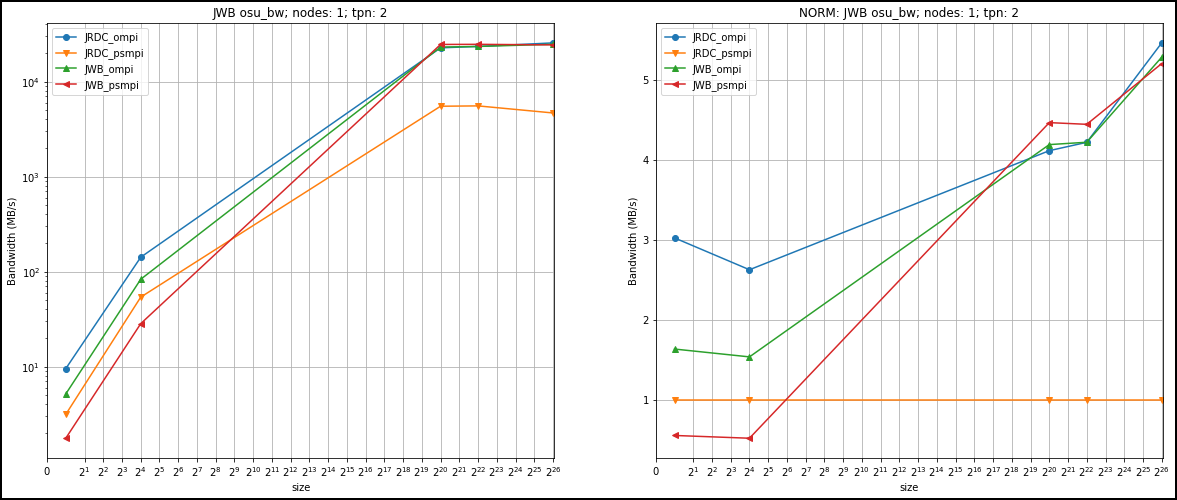

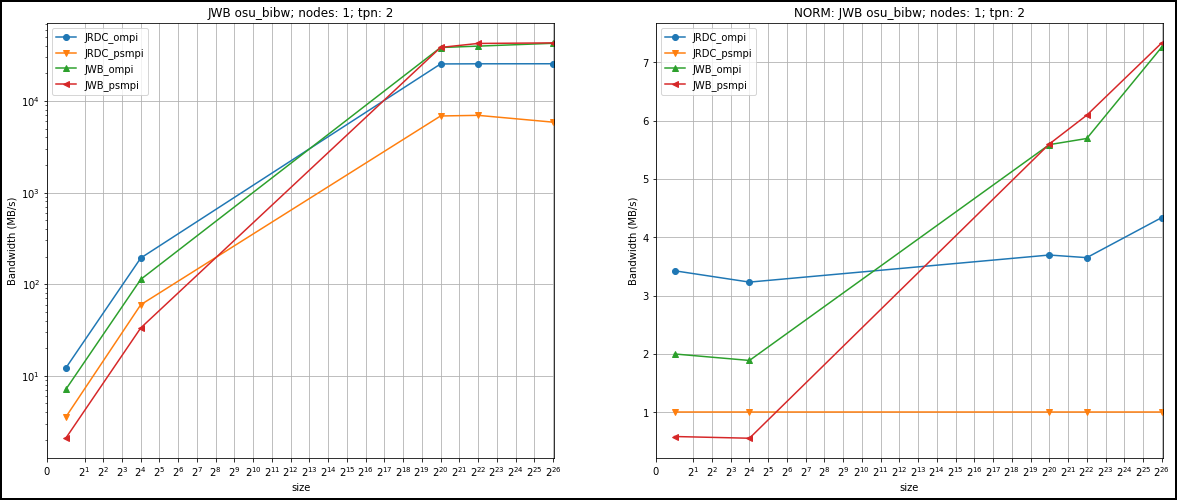

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

for p2p in ["osu_bw", "osu_bibw"]:
    if p2p in bench_data["osu_exe"].unique():
        print(p2p)
        if p2p in ["osu_bw", "osu_bibw"]:
            p2p_plot_norm(bench_data, p2p, 'result', 'JRDC_psmpi', 1)
    else:
        print('{}: no data available :/'.format(p2p))

# plot p2p - two nodes

osu_bw


result                               
mpi_dev  JRDC_ompi JRDC_psmpi  JWB_ompi JWB_psmpi
size                                             
1             3.83       2.72      2.44      1.16
16           61.53      43.23     38.87     18.52
1048576   12326.40   12312.57  24595.64  24542.04
4194304   12341.44   12337.49  24644.72  24654.79
67108864  12345.87   12344.93  24693.80  24691.90

result                               
mpi_dev  JRDC_ompi JRDC_psmpi  JWB_ompi JWB_psmpi
size                                             
1         1.408088        1.0  0.897059  0.426471
16        1.423317        1.0  0.899144  0.428406
1048576   1.001123        1.0  1.997604  1.993251
4194304   1.000320        1.0  1.997547  1.998364
67108864  1.000076        1.0  2.000319  2.000165

osu_bibw


result                               
mpi_dev  JRDC_ompi JRDC_psmpi  JWB_ompi JWB_psmpi
size                                             
1             6.23       3.92      4.38      1.60
16          100.48      62.67     70.57     25.18
1048576   24508.78   24536.26  42033.41  40810.51
4194304   24609.21   24616.85  42720.75  42777.22
67108864  24640.84   24641.49  43472.67  43908.73

result                               
mpi_dev  JRDC_ompi JRDC_psmpi  JWB_ompi JWB_psmpi
size                                             
1         1.589286        1.0  1.117347  0.408163
16        1.603319        1.0  1.126057  0.401787
1048576   0.998880        1.0  1.713114  1.663273
4194304   0.999690        1.0  1.735427  1.737721
67108864  0.999974        1.0  1.764206  1.781902

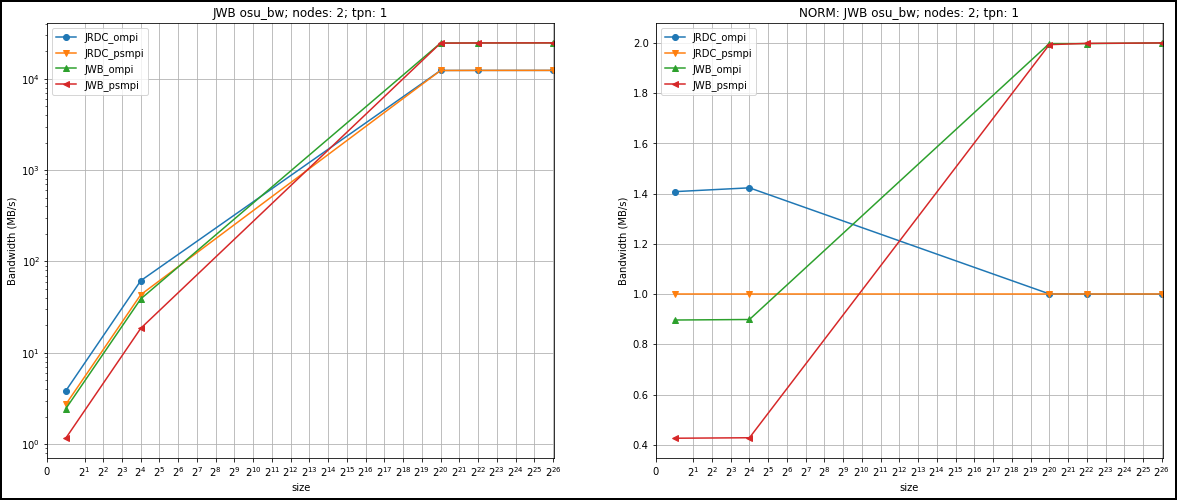

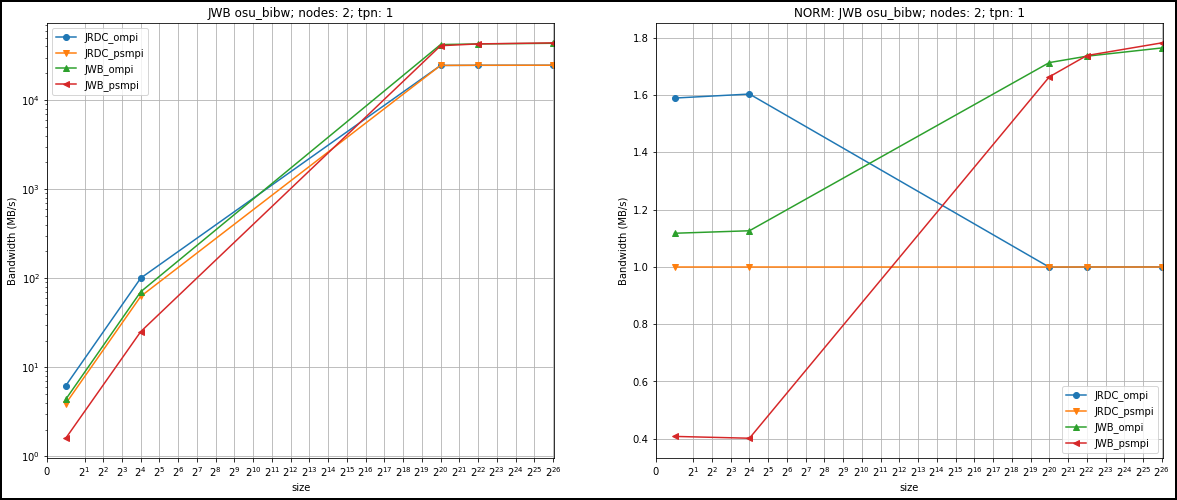

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

for p2p in ["osu_bw", "osu_bibw"]:
    if p2p in bench_data["osu_exe"].unique():
        print(p2p)
        if p2p in ["osu_bw", "osu_bibw"]:
            p2p_plot_norm(bench_data, p2p, 'result', 'JRDC_psmpi', 2)
    else:
        print('{}: no data available :/'.format(p2p))

# Plot latency - one node

,system,mpi,nodes,taskspernode,osu_exe,msg_size,runtime[sec],size,result,job_id,status,exit_code,mpi_dev
0,JWB,psmpi,1,2,osu_latency,0,1.76,0,0.73,6360426,COMPLETED,0:0,JWB_psmpi
1,JWB,ompi,1,2,osu_latency,0,1.30,0,0.40,6360391,COMPLETED,0:0,JWB_ompi
2,JRDC,psmpi,1,2,osu_latency,0,0.33,0,0.48,11123322,COMPLETED,0:0,JRDC_psmpi
3,JRDC,ompi,1,2,osu_latency,0,1.93,0,0.36,11123144,COMPLETED,0:0,JRDC_ompi


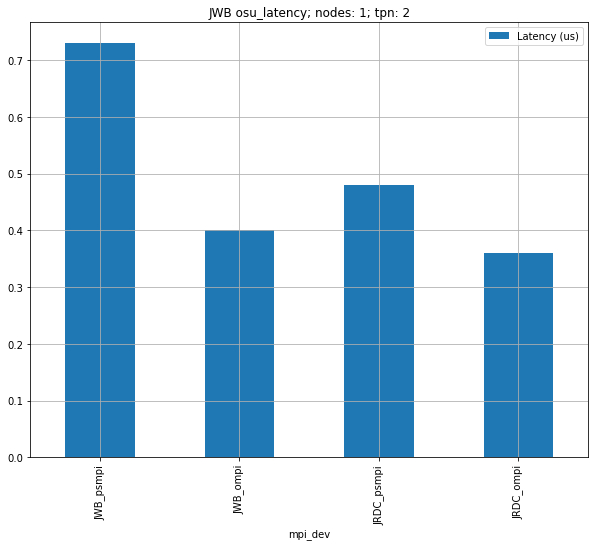

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

if "osu_latency" in bench_data["osu_exe"].unique():
    lat = bench_data.loc[bench_data["osu_exe"] == "osu_latency"].loc[bench_data["nodes"] == 1].reset_index(drop=True)
    display(lat)
    fig, ax = plt.subplots(figsize=(10, 8))
    lat.plot(kind='bar', x="mpi_dev", y=["result"],
             title="{} {}; nodes: {}; tpn: {}".format(lat["system"][0], lat["osu_exe"][0], lat["nodes"][0], lat["taskspernode"][0]), 
             grid=True, ax=ax);
    #ax.set_ylabel('Latency (us)')
    ax.legend(['Latency (us)'])
else:
    print("no osu_latency found!!")

# Plot latency - two nodes

,system,mpi,nodes,taskspernode,osu_exe,msg_size,runtime[sec],size,result,job_id,status,exit_code,mpi_dev
0,JWB,psmpi,2,1,osu_latency,0,3.58,0,2.31,6360437,COMPLETED,0:0,JWB_psmpi
1,JWB,ompi,2,1,osu_latency,0,2.51,0,1.79,6360404,COMPLETED,0:0,JWB_ompi
2,JRDC,psmpi,2,1,osu_latency,0,0.43,0,1.48,11123333,COMPLETED,0:0,JRDC_psmpi
3,JRDC,ompi,2,1,osu_latency,0,2.30,0,1.47,11123156,COMPLETED,0:0,JRDC_ompi


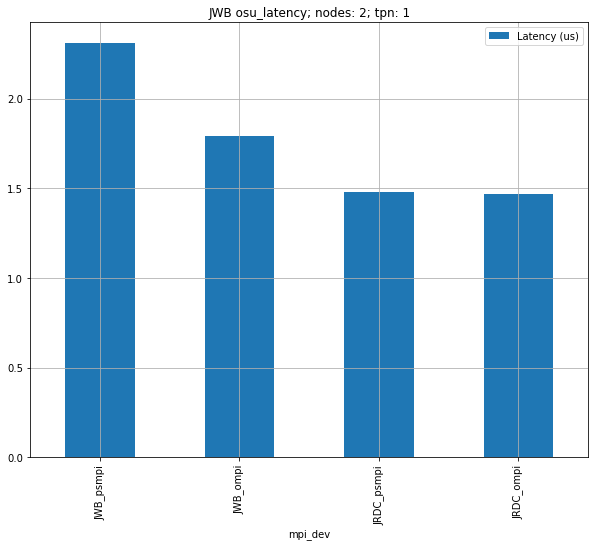

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

if "osu_latency" in bench_data["osu_exe"].unique():
    lat = bench_data.loc[bench_data["osu_exe"] == "osu_latency"].loc[bench_data["nodes"] == 2].reset_index(drop=True)
    display(lat)
    fig, ax = plt.subplots(figsize=(10, 8))
    lat.plot(kind='bar', x="mpi_dev", y=["result"],
             title="{} {}; nodes: {}; tpn: {}".format(lat["system"][0], lat["osu_exe"][0], lat["nodes"][0], lat["taskspernode"][0]), 
             grid=True, ax=ax);
    #ax.set_ylabel('Latency (us)')
    ax.legend(['Latency (us)'])
else:
    print("no osu_latency found!!")